# Dermatologist Sample Problem
This is the optional problem provided in module 3 of the Udacity Deep Learning nanodegree program.  I am building it on my own, after completing the course.

I'm trying to decide on a process flow.  Here I'll use the following phases:
1. Project setup & acquire data
2. Load & prepare the data (includes spot checking & sanity checking for cleanliness & appropriate content)
3. Build the model
4. ?

**Phase 1:** 
Data, provided by Udacity, already exists elsewhere in my local directory.  So this is probably a lot shorter than it would normally be.  This data set comes from [2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection] (https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a).

**Phase 2:**
* These images are large, and vary in size.  Since I'm looking for lots of details to help improve classification, I don't want to throw away lots of info by unnecessarily croping or downsampling the images. Therefore, I first need to go through the data set and figure out the min/max sizes.  From there I can figure out what is possible.
* Consisder using scaling like what is found in https://opensource.com/life/15/2/resize-images-python

In [51]:
# check if CUDA is available
import torch
train_on_gpu = torch.cuda.is_available()

# returns the number of GiB of cuda memory used
def memory_gb():
    max_val = 0
    if (train_on_gpu):
        gb_alloc = torch.cuda.memory_allocated() / 1024 / 1024 / 1024
        gb_res   = torch.cuda.memory_reserved() /  1024 / 1024 / 1024
        max_val = gb_alloc
        if gb_res > gb_alloc:
            max_val = gb_res
    return max_val

# compares current memory use to a previous value & returns the larger
def memory_max(prev_max):
    mem = memory_gb()
    if (mem > prev_max):
        return mem
    else:
        return prev_max

# printable report of cuda memory used
def memory_rpt(label=""):
    print("      {}: mem {:.3f} GB".format(label, memory_gb()))
    
# garbage collection
def memory_clean():
    if train_on_gpu:
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    

In [52]:
HEIGHT_GOAL = 768 #pixels

In [53]:
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    

# define training and test data directories
if train_on_gpu:
    data_dir = '/home/ubuntu/ml/dermatologist/data/' #for AWS server
else:
    data_dir = '/home/starkj/Udacity/repo/dermatologist/data/' #for local VM
    
train_dir = os.path.join(data_dir, 'train/')
val_dir   = os.path.join(data_dir, "valid/")
test_dir  = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['melanoma', 'nevus', 'seborrheic_keratosis']

# load and transform data using ImageFolder

# load and transform data using ImageFolder
### NOTE:  very important!  Some transforms work on PIL images and some on tensors.  Apply all the
###        PIL transforms first, then convert the result to a Tensor, then we can apply further
###        transforms if desired.

image_size = HEIGHT_GOAL
print("Using image size: ", image_size)

full1 = transforms.Compose([
                                     #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), #PIL only
                                     transforms.RandomResizedCrop(image_size, scale=(0.8, 1.2)),   #PIL or Tensor
                                     transforms.ColorJitter(brightness=0.2, contrast=0.2, #PIL or Tensor
                                                            saturation=0.1, hue=0.0),
                                     transforms.RandomHorizontalFlip(),                   #PIL or Tensor
                                     transforms.RandomVerticalFlip(),                     #PIL or Tensor
                                     transforms.RandomAffine(degrees=20, translate=(0.1, 0.1)), #PIL or Tensor
                                     transforms.ToTensor()])
no_xform = transforms.ToTensor()
crop_only = transforms.Compose([transforms.CenterCrop(image_size),
                                transforms.ToTensor()])

#####
##### select the transform set here!
#####
data_transform = full1



train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data   = datasets.ImageFolder(val_dir, transform=data_transform)
test_data  = datasets.ImageFolder(test_dir, transform=crop_only) #don't need to augment for the test

# print out some data stats
print('Num training images:   ', len(train_data))
print('Num validation images: ', len(val_data))
print('Num test images:       ', len(test_data))
print('training data = ', train_data)


CUDA is not available.  Training on CPU ...
Using image size:  768
Num training images:    27
Num validation images:  362
Num test images:        388
training data =  Dataset ImageFolder
    Number of datapoints: 27
    Root location: /home/starkj/Udacity/repo/dermatologist/data/train/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(768, 768), scale=(0.8, 1.2), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.9, 1.1], hue=None)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomAffine(degrees=(-20, 20), translate=(0.1, 0.1))
               ToTensor()
           )


In [54]:
##### data exploration support function
class ImageDatasetStats:
    def __init__(self):
        self.min_w  = 99999
        self.min_w2 = 99999 #second smallest
        self.max_w  = 0
        self.max_w2 = 0 #second largest
        self.min_h  = 99999
        self.min_h2 = 99999
        self.max_h  = 0
        self.max_h2 = 0

    # accessors
    def get_min_w(self):
        return (self.min_w, self.min_w2)

    def get_max_w(self):
        return (self.max_w, self.max_w2)

    def get_min_h(self):
        return (self.min_h, self.min_h2)

    def get_max_h(self):
        return (self.max_h, self.max_h2)
    
    # set the first and/or second smallest min dimension if new item exceeds
    def adjust_mins(self, min1, min2, val):
        if val < min1:
            min2 = min1
            min1 = val
        elif val < min2:
            min2 = val
        return (min1, min2)

    # set the first and/or second largest max dimension if new item exceeds
    def adjust_maxs(self, max1, max2, val):
        if val > max1:
            max2 = max1
            max1 = val
        elif val > max2:
            max2 = val
        return (max1, max2)

    # iterate through an image dataset, finding the first and second largest and smallest values in each dimension
    # (width and height)
    #    data: ImageFolder
    def find2dim_extremes(self, data):
        for i in range(len(data)):
            im = train_data.__getitem__(i)[0]
            h = im.shape[1]
            w = im.shape[2]
            mins = self.adjust_mins(self.min_w, self.min_w2, w)
            maxs = self.adjust_maxs(self.max_w, self.max_w2, w)
            self.min_w  = mins[0]
            self.min_w2 = mins[1]
            self.max_w  = maxs[0]
            self.max_w2 = maxs[1]
            
            mins = self.adjust_mins(self.min_h, self.min_h2, h)
            maxs = self.adjust_maxs(self.max_h, self.max_h2, h)
            self.min_h  = mins[0]
            self.min_h2 = mins[1]
            self.max_h  = maxs[0]
            self.max_h2 = maxs[1]

            if i%10 == 0:
                print(".", end = "")
            #print("\nimage shape = ", im.shape)
            #print("w = ", w, ", h = ", h)
            #print("width mins & maxes = ", self.min_w, self.min_w2, self.max_w, self.max_w2)
            #print("height mins & maxs = ", self.min_h, self.min_h2, self.max_h, self.max_h2)
   
    # iterate through a dataset and count how many images are in each size bin, both height & width
    # data: a DataSet of images
    def generate_histogram(self, minw, maxw, minh, maxh, num_bins, data):
        w_bin_width = int((maxw - minw)/num_bins)
        h_bin_width = int((maxh - minh)/num_bins)
        
        # initialize the arrays that will count the number of items in each size bin
        w_count = []
        h_count = []
        for i in range(num_bins):
            w_count.append(0)
            h_count.append(0)
        
        # determine the boundaries of each width bin
        w_bin_upper_bound = []
        for i in range(num_bins):
            w_bin_upper_bound.append(minw + (i+1)*w_bin_width - 1)
        w_bin_upper_bound[num_bins-1] = maxw #adjust size of final bin to account for bin width rounding
        #print("w_bin_upper_bound = ", w_bin_upper_bound)
        
        # determine the boudnaries of each height bin
        h_bin_upper_bound = []
        for i in range(num_bins):
            h_bin_upper_bound.append(minh + (i+1)*h_bin_width - 1)
        h_bin_upper_bound[num_bins-1] = maxh #adjust size of final bin to account for bin width rounding
        #print("h_bin_upper_bound = ", h_bin_upper_bound)
        
        # count the number of images that fall into each bin
        dsize = len(data)
        print("Binning images in dataset size ", dsize)
        for i in range(dsize):
            im = data.__getitem__(i)[0]
            h = im.shape[1]
            w = im.shape[2]
            #print("Image ", i, ": h = ", h, ", w = ", w)

            for j in range(num_bins):
                if w <= w_bin_upper_bound[j]:
                    w_count[j] += 1
                    break
            for j in range(num_bins):
                if h <= h_bin_upper_bound[j]:
                    h_count[j] += 1
                    break
        return w_count, h_count, w_bin_upper_bound, h_bin_upper_bound


In [55]:
##### data exploration only
'''

print("train_data shape = ", type(train_data))

# Make a loop to look at each image and determine range of sizes
stats = ImageDatasetStats()
stats.find2dim_extremes(train_data)
minw = stats.get_min_w()
maxw = stats.get_max_w()
minh = stats.get_min_h()
maxh = stats.get_max_h()
print(" ")
print("Width extremes  = ", minw, maxw)
print("Height extremes = ", minh, maxh)
'''


'\n\nprint("train_data shape = ", type(train_data))\n\n# Make a loop to look at each image and determine range of sizes\nstats = ImageDatasetStats()\nstats.find2dim_extremes(train_data)\nminw = stats.get_min_w()\nmaxw = stats.get_max_w()\nminh = stats.get_min_h()\nmaxh = stats.get_max_h()\nprint(" ")\nprint("Width extremes  = ", minw, maxw)\nprint("Height extremes = ", minh, maxh)\n'

### Handling variable image sizes

Clearly, from above, we have a wide range of image sizes, by almost 10x.  Cropping is not a good answer to this, because many of the images are framed tightly around the artifact of interest, so even a little cropping will be throwing away valuable information.  Other alternatives, which might be combined:

1) Downsample the larger images - probably useful for a certain range of downsampling (e.g. up to 4x?) but we stand to lose too much info in the largest images if they are downsampled a lot.  See https://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html

2) Throw out the smallest and/or largest images as outliers - if there are only a few way out on the tails of the distribution, this could help reduce the magnitude of the problem, but the statistics above only show that there are at least two images at each of the very extremes.

3) Build a network that handles variable image sizes - there are some techniques for this, but it involves advanced CNN construction, and adds difficulty to the final FC classification layer.  See:
    * https://stats.stackexchange.com/questions/388859/is-it-possible-to-give-variable-sized-images-as-input-to-a-convolutional-neural
    * https://www.reddit.com/r/MachineLearning/comments/akbe39/d_best_approach_to_variable_image_sizes_for_image/
    * Thesis paper in Downloads folder.

In [56]:
##### data exploration only
'''
stats = ImageDatasetStats()
res = stats.generate_histogram(576, 6748, 540, 4499, 11, train_data)

print("width counts = ", res[0])
print("width Ubound = ", res[2])
print("height counts =", res[1])
print("height Ubound =", res[3])
'''

'\nstats = ImageDatasetStats()\nres = stats.generate_histogram(576, 6748, 540, 4499, 11, train_data)\n\nprint("width counts = ", res[0])\nprint("width Ubound = ", res[2])\nprint("height counts =", res[1])\nprint("height Ubound =", res[3])\n'

### More on variable image sizes
As the cell above shows, the distribution is far from Gaussian, with ~1/3 of all the images in the lowest size bin.  The upper four size bins combined are about 7% of the images in the training set.  Therefore, for the sake of what is supposed to be a fairly simple exercise here, I'll ignore images with w > 4502 or h > 3052 pixels.  For the remainder, I'll downsample the larger ones and pad the smaller ones.  Since most of the images are in the smallest bin, I don't want to perturb them too much.  The smallest being h=540 and w=576, it probably isn't prudent to pad more than 30%, so set my input image size to 700x748 pixels.  Anything smaller will be padded; anything larger will be downsampled and/or cropped.

Problem is, the standard DataLoader won't accept input images that have variable sizes, per below, so need to figure out how to get around that.

In [57]:
##### data exploration only - can't use this as is
'''

# This code fragment pulled from Udacity DLND module 3 homework.
# Note that it only works if all images are identical size (dataiter assumes this)

import matplotlib.pyplot as plt

%matplotlib inline

# define dataloader parameters
batch_size = 32
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# obtain one batch of training images
dataiter = iter(train_loader) ######### THIS LINE BREAKS - can't handle variable image sizes
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print("images shape = ", images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])
'''


'\n\n# This code fragment pulled from Udacity DLND module 3 homework.\n# Note that it only works if all images are identical size (dataiter assumes this)\n\nimport matplotlib.pyplot as plt\n\n%matplotlib inline\n\n# define dataloader parameters\nbatch_size = 32\nnum_workers=0\n\n# prepare data loaders\ntrain_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, \n                                           num_workers=num_workers, shuffle=True)\nval_loader   = torch.utils.data.DataLoader(val_data, batch_size=batch_size,\n                                           num_workers=num_workers, shuffle=True)\ntest_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, \n                                           num_workers=num_workers, shuffle=True)\n\n# obtain one batch of training images\ndataiter = iter(train_loader) ######### THIS LINE BREAKS - can\'t handle variable image sizes\nimages, labels = dataiter.next()\nimages = images.numpy() # convert images 

### Loading image data of variable sizes

* There is an interesting answer for how to do this at https://discuss.pytorch.org/t/torchvision-and-dataloader-different-images-shapes/41026/3. Code from this page is copied below for ease of reading (without scroll bars).
* Another, maybe more useful answer, with links to lots of other answers: https://stackoverflow.com/questions/55041080/how-does-pytorch-dataloader-handle-variable-size-data

In [58]:
##### for image exploration only
### I don't think I want to use this, as it has masks that appear to be a substitute for resizing the images,
### but it looks like it requires each image to be in a fixed size tensor, which I don't want to do.

def default_collate(batch):
    """
    Override `default_collate` https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html#DataLoader

    Reference:
    def default_collate(batch) at https://pytorch.org/docs/stable/_modules/torch/utils/data/dataloader.html#DataLoader
    https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278/3
    https://github.com/pytorch/pytorch/issues/1512

    We need our own collate function that wraps things up (imge, mask, label).

    In this setup,  batch is a list of tuples (the result of calling: img, mask, label = Dataset[i].
    The output of this function is four elements:
        . data: a pytorch tensor of size (batch_size, c, h, w) of float32 . Each sample is a tensor of shape (c, h_,
        w_) that represents a cropped patch from an image (or the entire image) where: c is the depth of the patches (
        since they are RGB, so c=3),  h is the height of the patch, and w_ is the its width.
        . mask: a list of pytorch tensors of size (batch_size, 1, h, w) full of 1 and 0. The mask of the ENTIRE image (no
        cropping is performed). Images does not have the same size, and the same thing goes for the masks. Therefore,
        we can't put the masks in one tensor.
        . target: a vector (pytorch tensor) of length batch_size of type torch.LongTensor containing the image-level
        labels.
    :param batch: list of tuples (img, mask, label)
    :return: 3 elements: tensor data, list of tensors of masks, tensor of labels.
    """
    data = torch.stack([item[0] for item in batch])
    mask = [item[1] for item in batch]  # each element is of size (1, h*, w*). where (h*, w*) changes from mask to another.
    target = torch.LongTensor([item[2] for item in batch])  # image labels.

    return data, mask, target

In [59]:
import PIL
from PIL import Image

# Defining a custom collator for the DataLoader since its default assumes all raw images are identical
# size.  In our case they are not.  This function not only loads different size images, but manipulates
# them to be identical size (downsampling and cropping), because the CNN being used in this project
# is assuming that all images are identical size.
# This function is modified from https://jdhao.github.io/2017/10/23/pytorch-load-data-and-make-batch/
#
# `batch` is a list of tuple where first element is image tensor and
# second element is corresponding label
#
# return is a tuple of (data, target), where data is a tensor of shape [b, c, h, w] and
# target is a list of labels

AR_GOAL = 1.333333 # represents 768x1024
WIDTH_GOAL = HEIGHT_GOAL * AR_GOAL

def variable_collate(batch):
    data_list = []
    for item in batch:
        
        # get info on the raw image shape
        raw_image = item[0]
        h = raw_image.shape[1]
        w = raw_image.shape[2]
        ar = w/h
        
        # if the aspect ratio is larger than desired, then we scale by the height, otherwise by width
        if ar > AR_GOAL:
            scale_factor = HEIGHT_GOAL / h
        else:
            scale_factor = WIDTH_GOAL / w
        #print("In variable_collate: raw h = ", h, ", w = ", w, ", scale_factor = ", scale_factor)
        #print("  raw_image = ", raw_image.shape)
            
        # convert the raw_image tensor into a PIL Image object
        image = transforms.ToPILImage()(raw_image.squeeze_(0))
        #print("  After transform, image = ", image.size)
        
        # scale it, preserving aspect ratio
        resized = image.resize((int(w*scale_factor), int(h*scale_factor)))
        width = resized.width
        height = resized.height
        #print("  resized w = ", width, ", h = ", height)
            
        # now we have an image that doesn't necessarily match our goal aspect ratio, but is at least
        # as large as our goal dimensions in both directions; need to center-crop it - 
        # DON'T try to make it square!
        if width > WIDTH_GOAL:
            left = (width - WIDTH_GOAL) // 2
        else:
            left = 0
        right = left + WIDTH_GOAL #don't subtract 1; this is the next pixel beyond the edge of the image
        
        if height > HEIGHT_GOAL:
            upper = (height - HEIGHT_GOAL) // 2
        else:
            upper = 0
        lower = upper + HEIGHT_GOAL #don't subtract 1
        #print("  cropping to left = ", left, ", right = ", right, ", upper = ", upper, ", lower = ", lower)
        
        cropped_image = resized.crop((left, upper, right, lower))
        
        # convert the properly sized image back to a tensor
        cropped_tensor = transforms.ToTensor()(cropped_image).unsqueeze_(0)
        data_list.append(cropped_tensor)
        #print("  cropped_tensor = ", cropped_tensor.shape)
        

    # assemble all of the images into the data tensor for output
    data = torch.stack(data_list).squeeze()
    #print("  returning data = ", data.shape)
    
    # gather the target labels for each image
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    
    return [data, target]

In [60]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, collate_fn=variable_collate, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_data, collate_fn=variable_collate, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, collate_fn=variable_collate, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)



## Visualize training data

images type from dataiter =  <class 'torch.Tensor'>
images shape =  (20, 3, 768, 1024)


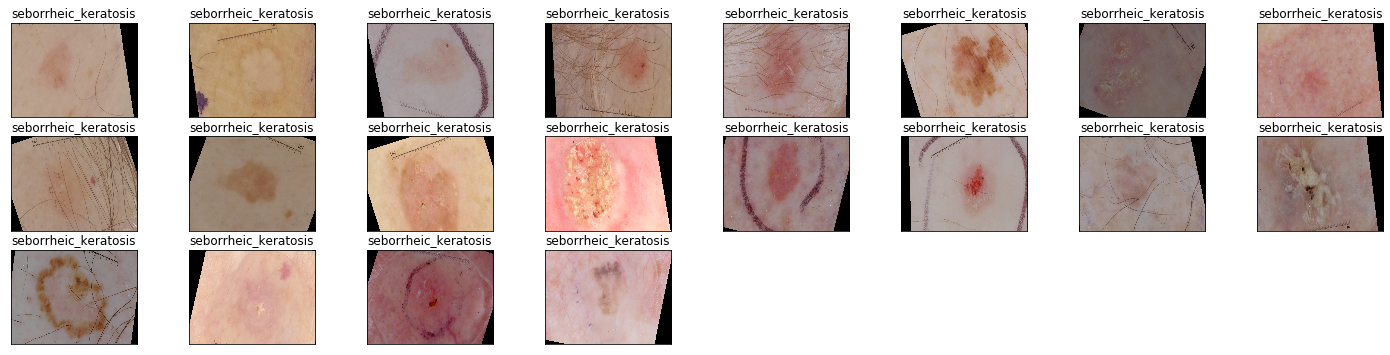

In [61]:
##### For image exploration only

# This code fragment pulled from Udacity DLND module 3 homework.
# Note that it only works if all images are identical size (dataiter assumes this)

import matplotlib.pyplot as plt

%matplotlib inline

# obtain one batch of training images - these need to be in a tensor of shape [b, c, w, h]
dataiter = iter(train_loader)
images, labels = dataiter.next()
print("images type from dataiter = ", type(images))
images = images.numpy() # convert images to numpy for display
print("images shape = ", images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8)) #numbers indicate horiz & vert spacing between images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, 32/4, idx+1, xticks=[], yticks=[]) #num rows, num images/row
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])


These images look pretty good!  Sizes of the objects of interest aren't as uniform as I'd like, but for the purposes of this exercise, I think close enough.  To get better, it's probably worth doing some pre-processing with some sort of edge/feature detection to define a bounding box in the raw image, then crop around that before doing the scaling I've done here.  

## Visualize validation & testing data

Validation samples


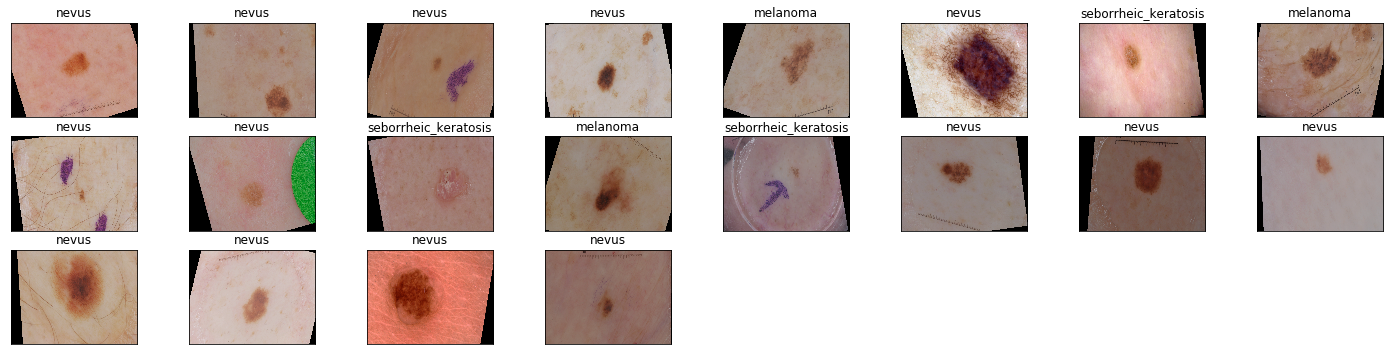

In [62]:
### Validation

# obtain one batch of training images - these need to be in a tensor of shape [b, c, w, h]
dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
print("Validation samples")
fig = plt.figure(figsize=(25, 8)) #numbers indicate horiz & vert spacing between images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, 32/4, idx+1, xticks=[], yticks=[]) #num rows, num images/row
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])


Test samples


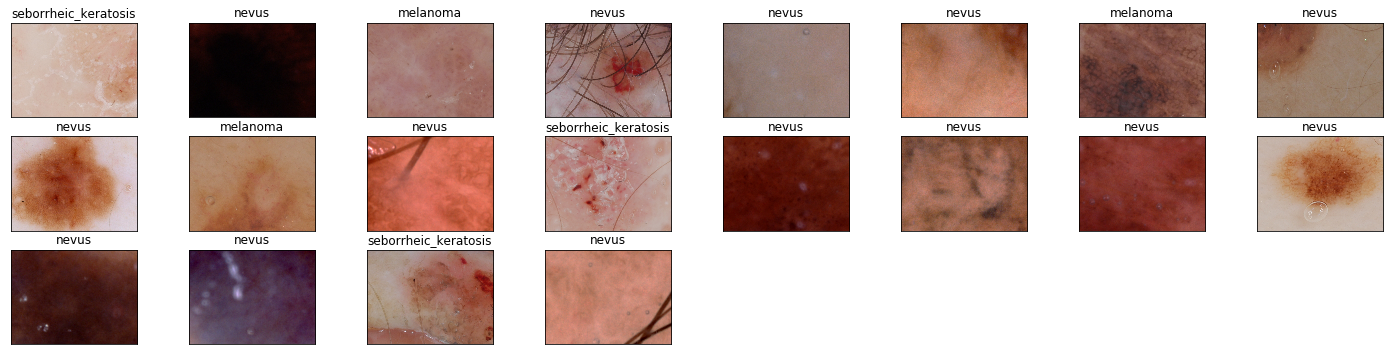

In [63]:
### Test

# obtain one batch of training images - these need to be in a tensor of shape [b, c, w, h]
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
print("\nTest samples")
fig = plt.figure(figsize=(25, 8)) #numbers indicate horiz & vert spacing between images
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, 32/4, idx+1, xticks=[], yticks=[]) #num rows, num images/row
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

These images look reasonably similar to the training images, ensuring that the validation & test processes will be subjected to the same kinds of data.

## Constructing the Model

I would like to use transfer learning with one of the big CNN's, but I need one that will use my chosen image size, or something close to it.
* VGG uses 224x224
* ResNet50 - not clear, but it looks like it can handle different sizes, up to 640 on short side.
* GoogLeNet 50 appears to take 224x224 also.

I'm starting to think all of these models are built for 224 square as a de facto standard for benchmarking.  Therefore, I choose to write my own model from scratch.  There is no doubt it will perform much worse than these world class models, but it will have one advantage in being able to use more input data (more pixels in the input images).

In [64]:
import torch.nn as nn
import torch.nn.functional as F

class SkinCancerCnn(nn.Module):
    def __init__(self):
        super(SkinCancerCnn, self).__init__()
        
        #self.CONV_OUT_FEATURES = int(128 * (768/2/2/2/2/2) * (1024/2/2/2/2/2)) #for 5 conv layers
        self.CONV_OUT_FEATURES = int(64 * (768/2/2/2/2) * (1024/2/2/2/2)) #for 4 conv layers
        print("CONV_OUT_FEATURES = ", self.CONV_OUT_FEATURES)
        
        # Applying batch norm to all but first and last layers, per guidance from the DL nanodegree
        # class, module 5.  Not clear why this restriction, however.
        
        #input images are 768x1024 pixels, full coloer (3 channels)
        self.c1 = nn.Conv2d(3, 8, 2, padding=1) #stride = 1

        self.c2 = nn.Conv2d(8, 16, 2, padding=1, bias=False)
        self.b2 = nn.BatchNorm2d(16)
        
        self.c3 = nn.Conv2d(16, 32, 2, padding=1, bias=False)
        self.b3 = nn.BatchNorm2d(32)
        
        self.c4 = nn.Conv2d(32, 64, 2, padding=1, bias=False) #must not use bias if using batchnorm!
        self.b4 = nn.BatchNorm2d(64)
        
        #self.c5 = nn.Conv2d(64, 128, 2, padding=1, bias=False)
        #self.b5 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        #linear classifier
        self.fc1 = nn.Linear(self.CONV_OUT_FEATURES, 3082)
        self.fc2 = nn.Linear(3082, 96)
        self.fc3 = nn.Linear(96, 3)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        #memory_rpt("forward top")
        #print("      at entry, x.shape = ", x.shape)
        
        x = F.leaky_relu(self.c1(x)) #output 8 x 768 x 1024
        x = self.pool(x)       #output 8 x 384 x 512
        
        # Experimenting with placing the BN function before or after the relu in each layer.
        # It seems there is some debate about which is best.
        x = self.c2(x)         #ouptut 16 x 384 x 512
        x = F.leaky_relu(x, negative_slope=0.05)
        x = self.b2(x)
        x = self.pool(x)       #output 16 x 192 x 256
        
        x = self.c3(x)         #output 32 x 192 x 256
        x = F.leaky_relu(x, negative_slope=0.05)
        x = self.b3(x)
        x = self.pool(x)       #output 32 x 96 x 128
        
        x = self.c4(x)         #output 64 x 96 x 128
        x = F.leaky_relu(x, negative_slope=0.05)
        x = self.b4(x)
        x = self.pool(x)       #output 64 x 48 x 64
        
        #x = self.c5(x)         #output 128 x 48 x 64
        #x = F.leaky_relu(x, negative_slope=0.05)
        #x = self.b5(x)
        #x = self.pool(x)       #output 128 x 24 x 32
        
        ### CONSIDER putting garbage collectiion in between these layers - worth some experimenting.
        #memory_rpt("  fwd conv ")
        
        conv_out = x.shape[1] * x.shape[2] * x.shape[3]
        #print("      after conv, x.shape = ", x.shape, "conv_out = ", conv_out)
        
        x = x.view(x.shape[0], -1) #flatten the convolved image
        #memory_rpt("  fwd view ")
        
        x = F.leaky_relu(self.fc1(x), negative_slope=0.05)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.05)
        x = self.dropout(x)
        # softmax will be applied during training (as part of loss function), not here
        x = F.leaky_relu(self.fc3(x), negative_slope=0.05) 
        
        return x
    

In [65]:
# Train the model

import time
import torch

best_checkpoint_file = "Empty" #global variable for use in testing

# Trains the model
# run_id:          identifier used in checkpoint file naming
# prev_run:        identifier used in file naming of previous checkpoint to be read at beginning
# starting_point:  input ID of the checkpoint file to use as a starting point (0 = no checkpoint)
# num_epochs:      number of epochs to run in this call
# save_interval:   save a checkpoint every this many epochs
# learn_rate:      the (constant) learning rate applied to the training loop

def train_it(run_id="XXX", prev_run="XXX", starting_point=0, num_epochs=10, save_interval=10, learn_rate=0.001):
    
    min_val_loss = 999999.0
    min_val_epoch = 0
    val_retry_limit = 10
    file_prefix = "model/derma"

    if starting_point == 0:
        print("Creating a new, untrained model.")
        model = SkinCancerCnn()
    else:
        checkpoint_file = "{}{}-{:03d}.pt".format(file_prefix, prev_run, starting_point)
        print("Retrieving partially trained model from ", checkpoint_file)
        model = torch.load(checkpoint_file)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learn_rate)

    print(model)
    print("LR = ", learn_rate)
    if train_on_gpu:
        model = model.cuda()
        print("Training on GPU")

    print("Entering training loop.")
    #memory_rpt()
    max_mem = memory_gb()
    start_time = time.perf_counter() #was time.clock()

    for epoch in range(starting_point, starting_point+num_epochs):
        model.train() #put it into training mode
        train_loss = 0.0

        for data, target in train_loader:
            if train_on_gpu:
                data = data.cuda()
                target = target.cuda()

            optimizer.zero_grad()
            output = model(data)
            #print("output = ", output)
            #print("target = ", target)

            #memory_rpt("  after model run")
            max_mem = memory_max(max_mem)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*data.size(0) #CrossEntropy already divides by num items in batch

            # sanity check samples from each class
            class_count = np.zeros(3)
            tgt_count = np.zeros(3)
            pred        = output.data.max(1, keepdim=True)[1]
            pred_values = output.data.max(1, keepdim=True)[0]
            for item in pred:
                class_count[item] += 1
            for item in target.cpu():
                tgt_count[item] += 1
            sum = 0.0
            for item in pred_values:
                sum += item
            avg_val = sum / len(pred_values)
            print("       Train batch: class_count = ", class_count, ", tgt_count = ", tgt_count,
                  ", avg class value = ", avg_val[0])

            # ensure garbage doesn't fill up the gpu memory
            memory_clean()

        train_loss /= len(train_loader.dataset)

        # validate the training on this epoch
        #print("    // Begin validation //")
        model.eval() #put into evaluation mode
        val_loss = 0.0
        class_count = np.zeros(3)
        tgt_count   = np.zeros(3)
        for data, target in val_loader:
            if train_on_gpu:
                data = data.cuda()
                target = target.cuda()
                model = model.cuda()     ### do we need this?  If so, do it in train loop above also.

            output = model(data)
            #memory_rpt("  after VAL model run")
            max_mem = memory_max(max_mem)
            loss = criterion(output, target)
            val_loss += loss.item()*data.size(0)
            
            # sanity check that we have samples from each class
            pred        = output.data.max(1, keepdim=True)[1]
            pred_values = output.data.max(1, keepdim=True)[0]
            for item in pred:
                class_count[item] += 1
            for item in target:
                tgt_count[item] += 1
            sum = 0.0
            for item in pred_values:
                sum += item
            avg_val = sum / len(pred_values)

            # ensure garbage doesn't fill up the gpu memory
            memory_clean()

        val_loss /= len(val_loader.dataset)

        # update the validation loss statistics
        flag = ' ' 
        if val_loss <= min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = epoch
            flag = '*'
            
            # save a copy of the model
            best_model = model
            
        # determine epoch duration and estimate remaining time
        current_time = time.perf_counter() #was time.clock()
        avg_duration = (current_time - start_time) / (epoch - starting_point + 1) / 60.0 #minutes
        remaining_time_minutes = (starting_point + num_epochs - epoch - 1) * avg_duration
        if remaining_time_minutes > 80:
            rem_time = remaining_time_minutes / 60.0
            time_est_msg = "{:4.1f} hr rem.".format(rem_time)
        else:
            time_est_msg = "{:.0f} min rem.".format(remaining_time_minutes)


        # show epoch results
        max_mem = memory_max(max_mem)
        memory_clean()
        print("///// Epoch {:3d}: train = {:.4f}, val = {:.4f}{}, mem {:.2f}/{:.2f} GB. Avg {:.1f} min/epoch; {}".format(
            epoch, train_loss, val_loss, flag, memory_gb(), max_mem, avg_duration, time_est_msg))
        print("      Val class counts: ", class_count, ", target counts: ", tgt_count,
              ", avg class value = ", avg_val[0])

        # save a checkpoint if it's appropriate
        if epoch > 0  and  epoch % save_interval == 0:
            save_file = "{}{}-{:03d}.pt".format(file_prefix, run_id, epoch)
            print("      Saving checkpoint ", save_file)
            torch.save(model, save_file)
        
        # determine if training is complete, based on validation loss hitting a minimum recently
        if epoch >= (min_val_epoch + val_retry_limit):
            print("      Training terminated due to no further decrease in validation loss.")
            break
            
    # save a checkpoint of the best epoch
    save_file = "{}{}-{:03d}.pt".format(file_prefix, run_id, min_val_epoch)
    print("      Saving best checkpoint ", save_file)
    torch.save(best_model, save_file)
    best_checkpoint_file = save_file

    print("Done training.")

In [66]:

RUN      = "18"  ##### set this before each run!
prev_run = ""
prev_run_start = 0

train_it(RUN, prev_run, starting_point=prev_run_start, num_epochs=50, learn_rate=0.000002)


Creating a new, untrained model.
CONV_OUT_FEATURES =  196608
SkinCancerCnn(
  (c1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=196608, out_features=3082, bias=True)
  (fc2): Linear(in_features=3082, out_features=96, bias=True)
  (fc3): Linear(in_features=96, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
LR =  2e-06
En

KeyboardInterrupt: 

### Test the model

Pull in the checkpoint file that performed the best above and run it on the test data set.

In [ ]:
# this is adapted from my homework on the Udacity dog_app

import numpy as np

def test_it(test_file=None):
    
    # load the file
    if test_file == None:
        model = torch.load(best_checkpoint_file)
    else:
        model = torch.load(test_file)
    
    # monitor test loss and accuracy
    test_loss = 0.0
    correct = 0.0
    total = 0.0
    correct_by_class = np.zeros(3)
    print("correct_by_class = ", correct_by_class)

    criterion = nn.CrossEntropyLoss()
    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            model = model.cuda()

        output = model(data)
        loss = criterion(output, target)
        
        # update average test loss 
        test_loss += (1 / (batch_idx + 1)) * (loss.data - test_loss)
        # convert output probabilities to predicted class - max() here returns a tuple of (values, indices),
        #     where values is a tensor of size [batch_size, 3] holding the predictions of each of the three
        #     output classes.  incides is a tensor of size [batch_size] holding the index of the max value 
        #     in each row, which corresponds to the winning class.
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        print("output = ", output)
        
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.5f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100.0 * correct / total, correct, total))


In [ ]:
print(best_checkpoint_file)

In [ ]:
test_file = "model/derma17-026.pt"

test_it(test_file)

### Using AWS
Ran the above code for 2 epochs on the local computer to determine that the model is functional and seems to be trainable (loss decreased).

Now it's time to move it to an AWS instance in order to train.  I discovered my existing instance does not have any storage attached (I had been using a separate EBS volume, and deleted it after class).  Therefore, choosing a new instance:  <code>g2.2xlarge</code>, which has 1 GPU and 2 cores of CPU (2 threads each) and 16 GB of memory.

System volume is /dev/sda1.  Working data storage is on /dev/sdb (60 GB).  Instance ID is i-0be255fe5cb1becf1.  Username is default "ubuntu".  Changed pwd to H1.

### Local Ubuntu VM disk size problem

Diversion for a few days...

Got into trouble by filling up my hard drive.  Took a long time to move data off and back it up, then figure out how to extend the drive space in VMWare.  
* First, shut down the VM, then in Settings select Extend drive space.  This enlarges the physical drive only.  It doesn't extend the partition or the file system in the partition.
* Next use gparted to enlarge the physical partition (I did not have a logical volume, so LVM was not an option).  Decent instructions here to get started, then just follow intuitin and the UI:  https://unix.stackexchange.com/questions/196512/how-to-extend-filesystem-partition-on-ubuntu-vm

### Data transfer

Now that VM drive space problem is solved, I re-downloaded all of the data from the original Udacity problem and moved it into my Github repo under dermatologist/data.  This took quite a while, as each push has to complete within a certain timeout period (not clear to me what causes that, but it appears it's my host screen saver time that essentially shuts down VM activity).

Attempted to pull the entire dermatologist branch down to my AWS server, but ran out of drive space there. Cleaned it up and pulled all the data.  Now ready to run.

# Training the model

### Error using GPU
Upon first run, I got the following error:

<code>
/home/ubuntu/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:102: UserWarning: 
    Found GPU0 GRID K520 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
</code>

It would appear that I've purchased an inappropriate server for my work!  I currently have Pytorch 1.6.0 installed.  Forums say to drop back to 0.3.0 to get support for cuda capability 3.0.  That's a long way back!

In [ ]:
print(torch.__version__)

device_id = torch.cuda.current_device()
gpu_properties = torch.cuda.get_device_properties(device_id)
print("Found %d GPUs available. Using GPU %d (%s) of compute capability %d.%d with "
      "%.1fGb total memory.\n" % 
      (torch.cuda.device_count(),
      device_id,
      gpu_properties.name,
      gpu_properties.major,
      gpu_properties.minor,
      gpu_properties.total_memory / 1e9))


9/27/20:

AWS says that

* p3.2xlarge instance has one V100 GPU, which has compute capability of 7.0, plus 61 GB memory for $3.06/hr.

* p2.xlarge instance has one K80 GPU, which provides compute capability of 3.7, plus 61 GB memory for $0.9/hr.

* The g3 and g4 instances are intended for graphics-intense apps, and don't seem to provide an advantage here.

I probably want to use the Deep Learning AMI (DLAMI), described here: https://docs.aws.amazon.com/dlami/latest/devguide/what-is-dlami.html

I want to use the Ubuntu 18.04 Conda variant.  I don't believe this is what I have on the 664 instance from class, so I'll create a new one, just to be sure.

10/24/20:

Created a new EC2 instance, **ID = i-03ffe00145cb0b929**
* Built from DLAMI Ubuntu 18.04 v35.0
* Reuses security group created on 9/10, ID = sg-0b8d086b2fa6881a7 (launch-wizard-4), which is wide open on 5 ports.
* Storage is EBS volume ID = vol-043c36a11deb7c7cd, which is 130 GB of gp2, and marked as delete on termination.
    * The AMI takes up 74 GB
    * The Udacity repo currently takes up 21 GB
    * Total disk usage is 90 GB before I even start working.
    * This storage persists between shutdowns of the instance.
* Added .credentials file and user/security info to the .gitconfig file to enable pushing to the repo.

* Found that torch & torchvision were not installed, despite the conda list being very long (and I thought the advertised DL AMI included pytorch).
    * Resolved that by using command <code>conda install -c pytorch pytorch torchvision</code>
    
* **AI:** Tried to launch classroom instance (b664) as a comparison for network access configs, since it allowed me to access via https and have a terminal on a web page, which was handy since it is visually different from the normal Ubuntu VM terminals.  I currently cannot do this with my new machine, so I ssh via VM terminals.



## After false starts, training for real

### First run (10/26/20)
First real training run on AWS p2.xlarge with GPU:
* Hyperparams: 
<code>
    LR = 0.01
    CONV_OUT_FEATURES =  98304
    SkinCancerCnn(
      (c1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (c2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (c3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (c4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (c5): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=98304, out_features=1024, bias=True)
      (fc2): Linear(in_features=1024, out_features=3, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
</code>
* Result:  Never saw any training or validation loss decrease.  Stopped at 1.10 after epoch 6.

### Run 2 (10/26/20)
Adjusted LR and dropout.
* Hyperparams:
<code>
    CONV_OUT_FEATURES =  98304
    SkinCancerCnn(
      (c1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (c2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (c3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (c4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (c5): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=98304, out_features=1024, bias=True)
      (fc2): Linear(in_features=1024, out_features=3, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    Training on GPU
    LR =  0.001
</code>
* Result:  Slightly better. Went 12 epochs, but ended with val loss = 1.08.

### Run 3 (11/1/20)
Adjusted LR
* Hyperparams:
<code>
    CONV_OUT_FEATURES =  98304
    SkinCancerCnn(
      (c1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (c2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (c3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (c4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (c5): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=98304, out_features=1024, bias=True)
      (fc2): Linear(in_features=1024, out_features=3, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    Training on GPU
    LR =  0.0001
</code>
* Result:  Better still.  Best result: Epoch 30: training loss = 0.899543   validation loss = 1.024926*
    * Need to add in checkpoint file saving so I don't have to start from scratch each time. This is a slow network to train.
    * Need to add batchnorm2d; also consider doing the maxpool after every 2 layers.
    
### Run 4 (11/2/20)
* Added batch normalizing to layers 2, 3, 4
* Added storage of checkpoint files periodically

* Hyperparams:
<code>
    CONV_OUT_FEATURES =  98304
    SkinCancerCnn(
      (c1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (c2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (b2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (c3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (b3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (c4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (b4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (c5): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=98304, out_features=1024, bias=True)
      (fc2): Linear(in_features=1024, out_features=3, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    LR = 0.0001
</code>

* Result: No good.  First epoch gave train loss = 0.89166, val loss = 1.02633, then it got fluctuated around the same values for the next 5 epochs.
    * Getting CUDA memory errors now, when I rerun the model.  Need to restart the jupyter server.  This might indicate there is a problem in the way I implemented the batchnorm.

### Run 5 (11/2/20)
* Adjusted learning rate, since it seems it may have been bouncing around a minimum hole.

* Hyperparams:
<code>
    Creating a new, untrained model.
    CONV_OUT_FEATURES =  98304
    SkinCancerCnn(
      (c1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (c2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (b2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (c3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (b3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (c4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (b4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (c5): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=98304, out_features=1024, bias=True)
      (fc2): Linear(in_features=1024, out_features=3, bias=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    Training on GPU
    LR =  2e-05
</code>

* Result:  Crapped out right away after restarting jupyter server.  I definitely have a memory management problem in my code somewhere.  Will need to investigate later.

### Run 6 (11/7/20)
* Added memory reporting code from Udacity module 5 dog app.  Crapped out immediately in the backward() method, which suggests I am probably using the batchnorm incorrectly.
* Removed all use of batchnorm, going back to the way it was for run 3.  Still got a rapid memory error after 4 batches.
* Replaced separate calls to F.relu() to inline them as they were for run 3.  Memory climbed for the first 4 batches, then leveled out at 10.143 GB for 30 more batches. On the 35th batch cuda ran out of memory in the call to forward().

### Run 7 (11/11/20)
* Compared to the run 3 version (from commit 673f046e).  The only difference is the checkpoint file management.  So I commented this out and ran, even with the same learning rate as run 3, just to re-establish baseline performance.
* Still running out of memory early in the first validation loop.  Added a bunch of memory reports throughout.
* Realized I have been using batch size of 64, vice 32 used on run 3.  Returned to 32.
* This ran 2 complete epochs and started a third, which looks like it might be able to finish. But I noticed that memory was still creeping up in between batches sometimes, so added garbage collection within each batch loop.  This helps a tremendous amount!  Ready to start rockin again.

### Run 8 (11/11/20)
* Changed learning rate.  Cleaned up memory debugging print statements.
* Left the batchnorm statements commented out.
* Hyperparams:
<code>
Creating a new, untrained model.
CONV_OUT_FEATURES =  98304
SkinCancerCnn(
  (c1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c5): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=98304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Training on GPU
LR =  2e-05
</code>

* Result:  consistently reducing loss over first 14 epochs, with constant memory use at end of each epoch (4.762 GB). I stopped it prematurely because it was learning very slowly and I now feel I understand how to apply batchnorm.

### Run 9 (11/12/20)
* Changed dropout from 0.5 to 0.2 (using batchnorm will make this less necessary)
* Added batchnorm2d in 4th layer only.  I want to introduce it slowly to understand the implications on memory use.
* Hyperparams:
<code>
Creating a new, untrained model.
CONV_OUT_FEATURES =  98304
SkinCancerCnn(
  (c1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c5): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=98304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Training on GPU
LR =  2e-05
</code>
    
* Results:  
    * Epoch 3 was lowest val loss (1.028), but it started decreasing more reapidly than before, at same LR.
    * Memory use was 3.80 / 9.54 GB (max avaliable is 11.1 GB).
    
### Run 10 (11/14/20)
* Improved checkpoint file naming & saving logic.
* Adjusted LR up to 0.0001 based on documented improvements in learning with batch normalization.
* Added batchnorm layer 3.  This isn't all I want to add, but want to gauge effect on memory use gradually.
* Hyperparams:
<code>
Creating a new, untrained model.
CONV_OUT_FEATURES =  98304
SkinCancerCnn(
  (c1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c5): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=98304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Training on GPU
LR =  0.0001
</code>

* Result:  val loss was 1.03 on epoch 0, then increased from there.  Memory was mem 3.93/9.92 GB.

### Run 11 (11/14/20)
* Added layer 2 batchnorm.
* Hyperparams:
<code>
Creating a new, untrained model.
CONV_OUT_FEATURES =  98304
SkinCancerCnn(
  (c1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c5): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=98304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Training on GPU
LR =  0.0001
</code>

* Result:  val loss was 1.03 on epoch 0, then increased from there.  Memory was 4.19/10.67 GB.

### Run 12 (11/14/20)
* Reducing batch size from 32 to 24 to avoid memory limits.
* Changing learning rate smaller.
* Hyperparams:
<code>
Creating a new, untrained model.
CONV_OUT_FEATURES =  98304
SkinCancerCnn(
  (c1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c5): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=98304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Training on GPU
LR =  1e-05
</code>

* Result:  val loss hit min of 1.02 on epoch 2. Model correctly saved.  Memory 2.76/9.24 GB.

### Run 13 (11/14/20)
* Added third FC classification layer. Set the layer sizes as equally distributed along the log scale between 98304 and 3.
* Hyperparams:
<code>
Creating a new, untrained model.
CONV_OUT_FEATURES =  98304
SkinCancerCnn(
  (c1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c5): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=98304, out_features=3082, bias=True)
  (fc2): Linear(in_features=3082, out_features=96, bias=True)
  (fc3): Linear(in_features=96, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Training on GPU
LR =  1e-05
</code>

* Result:  val loss dropped steadily down to 1.05 for first 12 epochs, where I stopped it in order to experiment with other stuff.  Memory use was 3.24/9.71 GB.

### Run 14 (11/14/20)
* Added batchnorm to conv layer 5
* Reduced batch size to 20 (see results below).
* Hyperparams:
<code>
Creating a new, untrained model.
CONV_OUT_FEATURES =  98304
SkinCancerCnn(
  (c1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c5): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=98304, out_features=3082, bias=True)
  (fc2): Linear(in_features=3082, out_features=96, bias=True)
  (fc3): Linear(in_features=96, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Training on GPU
LR =  1e-05
</code>

* Result: cuda ran out of memory immediately, so I reduced batch size to 20.  However, realized that it may have been a result of killing the previous run, leaving the gpu polluted.  Still, the extra batchnorm is adding some memory, so decided to be safe and leave it.
    * Val loss got down to 1.02 on epoch 7.  Memory was 3.88/8.55 GB.
* **Note:** There seems to be quite a debate about whether batchnorm should be performed before or after the activation function.  The original paper put it before.  But others seem to find that it is better after.  I agree with the principle of putting it before, since normalizing after the nonlinear activation feels like it is making a false adjustment on only the "filtered" outputs.  However, these are the actual outputs of the layer, which is the true input to the next layer.  And it seems that several people have, at least anecdotally, experienced that doing so after the activation provides improved performance.  See 
    * https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/
    * https://forums.fast.ai/t/questions-about-batch-normalization/230/8

### Run 15 (11/14/20)
* Moved the batchnorm functions to after the relu functions in each of the conv layers 2-5.
* Hyperparams:
<code>
Creating a new, untrained model.
CONV_OUT_FEATURES =  98304
SkinCancerCnn(
  (c1): Conv2d(3, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (c2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c5): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
  (b5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=98304, out_features=3082, bias=True)
  (fc2): Linear(in_features=3082, out_features=96, bias=True)
  (fc3): Linear(in_features=96, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Training on GPU
LR =  1e-05
</code>

* Result: Best epoch was #8, with losss of 1.0306, but epoch 10 showed 1.0308, the second-lowest, with a downward trend in training loss, so I thought it might start going down again.  Since I have a checkpoint of that one, I'd like to try continuing from there.  Memory was 4.10/8.57 GB.

### Run 16 (11/15/20)
* Continuing from run 15, reading from the checkpoint 8, but using a lower learning rate.  This is a test of starting from a checkpoint as much as anything.
* New LR = 2e-6

* Result:  val loss started out higher than the from run 15 where it left off (1.0493 vs 1.0306 on run 15).  Val loss intermittently found new lows, but the progress was not monotonic.  Even the training loss moves in waves, hitting a minimum, then retreating for 3 or 4 epochs before finding a new low.  Therefore, I think the termination criterion of > 6 epochs with no new low is too tight.
* Best epoch was #25, with val loss of 1.0296.  Memory was 3.88/8.55 GB.

* It appears that I've hit a wall, unable to find any way for the val loss to go below 1.02 or so.  Need to look for an alternative architecture.

### Run 17 (11/15/20)
* Looked at visual sampling of the validation & test data sets to ensure that the data there are also reasonable, which they appear to be.
* Reduced some of the data manipulations in the transforms, feeling that this may be too much variation given the small sample sizes:
    * Scaling was in (0.4, 1.1), changed to (0.8, 1.2)
    * affine rotation was 30 deg, changed to 20 deg
    * affine translation was 0.2, changed to 0.1
    * affine saturation was 0.2, changed to 0.1
    * affine hue was 0.2, changed to 0.0, since test images looked mostly brown and train/val samples were lots of bright weird colors.
* Increased the validation retry limit from 6 epochs to 10 epochs.
* Added logic to run final test.


* Result:  
    * **The classifier doesn't work at all.**  When running the test code I realized that the model had been trained to always guess class 1 (nevus), and it was right 65% of the time, which is why the losses hit a plateau.  I need to figure out how to build or train a classifier to reach for better results than just guessing the most common class all the time.
    * I ran this on my local VM (cpu only).  The epoch times were only slightly longer (\~16 min) than what I had experienced on the AWS server with a modern GPU (\~12-13 min).  
    * As a further experiment, I rearranged the training code to define the optimizer before moving the model to the gpu, since optimizer needs model params as an input, thinking that interaction may pull it out of the gpu.  Otherwise, I verified that the data, targets and model are all being moved to the gpu before starting both the training loop and the validation loop.  On next run on AWS GPU, I get 12 min/epoch, which isn't a noticeable difference, so the code arrangement didn't matter.  This makes me wonder if I'm doing something else wrong to not take full advantage of the GPU.

### Run 18 (11/21/20)

* Studied https://stackoverflow.com/questions/41488279/neural-network-always-predicts-the-same-class for some good suggestions on how to trouble-shoot the mis-classification problem.
* Removed layer 5 to simplify.
* Ran just a batch of melanoma samples (only 51 of training set were kept, and none of the other two classes).
    * Result:  in 3 epochs it learned to identify everything as a melanoma, whether it is or not.  It actually appears to learn this in the first epoch (3 batches), but the validation pass in that epoch showed every data sample was classified as a nevus.  I'm not sure how that happens.  Partial output follows:
    <code>
    Entering training loop.
       Train batch: class_count =  [4. 7. 9.] , tgt_count =  [20.  0.  0.]
       Train batch: class_count =  [16.  4.  0.] , tgt_count =  [20.  0.  0.]
       Train batch: class_count =  [11.  0.  0.] , tgt_count =  [11.  0.  0.]
///// Epoch   0: train loss = 1.0184, val loss = 1.0815*, mem 0.00/0.00 GB. Avg 3.1 min/epoch;  2.5 hours rem.
      Pred counts:  [  0. 362.   0.] , target counts:  [ 70. 226.  66.]
       Train batch: class_count =  [20.  0.  0.] , tgt_count =  [20.  0.  0.]
       Train batch: class_count =  [20.  0.  0.] , tgt_count =  [20.  0.  0.]
       Train batch: class_count =  [11.  0.  0.] , tgt_count =  [11.  0.  0.]
///// Epoch   1: train loss = 0.5527, val loss = 1.0973 , mem 0.00/0.00 GB. Avg 3.0 min/epoch;  2.4 hours rem.
      Pred counts:  [313.  49.   0.] , target counts:  [ 70. 226.  66.]
    </code>
* Ran just a batch of sebhorreic samples (only 27 of them, with nothing in other two classes). 
    * Result:  similar to those for the melanoma-only run, but it took a little longer to convince the net that this is the true class of choice, maybe because it had fewer data point per epoch?
    <code>
    Entering training loop.
       Train batch: class_count =  [ 0. 10. 10.] , tgt_count =  [ 0.  0. 20.]
       Train batch: class_count =  [0. 0. 7.] , tgt_count =  [0. 0. 7.]
///// Epoch   0: train loss = 0.9849, val loss = 1.0800*, mem 0.00/0.00 GB. Avg 3.0 min/epoch;  2.5 hours rem.
      Pred counts:  [  0. 362.   0.] , target counts:  [ 70. 226.  66.]
       Train batch: class_count =  [ 0.  0. 20.] , tgt_count =  [ 0.  0. 20.]
       Train batch: class_count =  [0. 0. 7.] , tgt_count =  [0. 0. 7.]
///// Epoch   1: train loss = 0.5979, val loss = 1.0837 , mem 0.00/0.00 GB. Avg 3.0 min/epoch;  2.4 hours rem.
      Pred counts:  [  0. 362.   0.] , target counts:  [ 70. 226.  66.]
       Train batch: class_count =  [ 0.  0. 20.] , tgt_count =  [ 0.  0. 20.]
       Train batch: class_count =  [0. 0. 7.] , tgt_count =  [0. 0. 7.]
///// Epoch   2: train loss = 0.3321, val loss = 1.0880 , mem 0.00/0.00 GB. Avg 3.0 min/epoch;  2.3 hours rem.
      Pred counts:  [  0. 279.  83.] , target counts:  [ 70. 226.  66.]
       Train batch: class_count =  [ 0.  0. 20.] , tgt_count =  [ 0.  0. 20.]
       Train batch: class_count =  [0. 0. 7.] , tgt_count =  [0. 0. 7.]
///// Epoch   3: train loss = 0.2090, val loss = 1.0933 , mem 0.00/0.00 GB. Avg 3.0 min/epoch;  2.3 hours rem.
      Pred counts:  [  0.   1. 361.] , target counts:  [ 70. 226.  66.]
    </code>
    
* Ran the same training sample again with some minor changes (notably, leaky_relu now using negative_slope=0.05, not the default 0.01) and more intermediate print stmts.
    * It now seems that the training loop quickly converges to the right answer, but the validation loop insists on moving toward class 1 (nevus), like it's running a different model than what came out of the training loop.  In the val loop, the avg output values are very close to zero, and some are negative. I thought it was going to be guaranteed to be in [0, 1].  Advice article referenced above says don't use softmax if outputs include negatives.